In [111]:
import networkx as nx
from networkx.algorithms.shortest_paths.weighted import all_pairs_dijkstra_path_length
import numpy as np
# Assuming you have a function or library for the Sinkhorn algorithm


In [112]:
def add_two_hop_edges(G_adjusted, initial_weight=1):
    """
    Add edges for 2-hop neighbors in the graph G_adjusted that are not directly connected.
    Each new edge will have the specified initial weight.

    Parameters:
    - G_adjusted: A NetworkX graph
    - initial_weight: The initial weight to assign to new 2-hop edges
    """
    for node in G_adjusted.nodes():
        # Find all neighbors of the current node in G_adjusted
        neighbors = set(nx.neighbors(G_adjusted, node))
        # Also include the node itself to exclude its direct edges
        neighbors.add(node)
        
        # Find 2-hop neighbors: neighbors of the neighbors, excluding the node itself and its direct neighbors
        two_hop_neighbors = set()
        for neighbor in neighbors:
            if neighbor != node:  # Exclude the node itself
                two_hop_neighbors.update(nx.neighbors(G_adjusted, neighbor))
        two_hop_neighbors -= neighbors  # Exclude direct neighbors and the node itself
        
        # Add edges with the initial weight
        for two_hop_neighbor in two_hop_neighbors:
            if not G_adjusted.has_edge(node, two_hop_neighbor):  # Check if the edge does not already exist
                G_adjusted.add_edge(node, two_hop_neighbor, weight=initial_weight)

    return G_adjusted

In [113]:
def create_stochastic_block_model(block_sizes, prob_matrix):
    G = nx.stochastic_block_model(block_sizes, prob_matrix)
    return G

block_sizes = [10, 10]  # Example sizes of blocks
prob_matrix = [
    [0.25, 0.05],  # Intra-block and inter-block connection probabilities
    [0.05, 0.25]
]
G = create_stochastic_block_model(block_sizes, prob_matrix)  # Your original graph
G_adjusted = G.copy()
G_with_2_hop = add_two_hop_edges(G_adjusted, initial_weight=1)  # Add 2-hop edges with an initial weight
print(G.number_of_edges())
print(G_with_2_hop.number_of_edges())


29
123


In [114]:
def distance_matrix_cutoff_2(G):
    paths = dict(all_pairs_dijkstra_path_length(G, cutoff=2))
    # Convert paths to distance matrix if needed
    # This part depends on whether you need the raw paths dict or a matrix representation
    return paths

distance_matrix_original = distance_matrix_cutoff_2(G)


In [115]:
import numpy as np

def assign_exponential_weights(G, scale=1.0):
    """
    Assign weights to the edges of the graph G based on an exponential distribution.
    
    Parameters:
    - G: A NetworkX graph
    - scale: The scale parameter (1/lambda) of the exponential distribution
    """
    for u, v in G.edges():
        weight = np.random.exponential(scale)
        G[u][v]['weight'] = weight

    return G

In [116]:
def compute_distance_matrix(G):
    """
    Compute the distance matrix for all pairs of nodes in the graph G using the edge weights.
    
    Parameters:
    - G: A weighted NetworkX graph
    """
    # Compute shortest path lengths for all pairs of nodes
    path_lengths = dict(nx.all_pairs_dijkstra_path_length(G, weight='weight'))
    
    # Convert to a matrix (optional, depending on your requirements)
    nodes = list(G.nodes())
    distance_matrix = np.zeros((len(nodes), len(nodes)))
    
    for i, node_i in enumerate(nodes):
        for j, node_j in enumerate(nodes):
            distance_matrix[i, j] = path_lengths[node_i].get(node_j, np.inf)
    
    return distance_matrix


In [117]:
G_weighted = assign_exponential_weights(G_with_2_hop, scale=1.0)  # Adjust scale as needed
distance_matrix_weighted = compute_distance_matrix(G_weighted)

In [118]:
def calculate_modularity(G, communities):
    """
    Calculate the modularity of a given partition of the network.

    Parameters:
    - G: NetworkX graph
    - communities: A list of sets, where each set contains the nodes in a community

    Returns:
    - modularity: The modularity of the partition
    """
    if G.is_directed():
        raise ValueError("This function does not support directed graphs.")
    
    m = G.size(weight='weight')
    if m == 0:
        raise ValueError("The graph has no edges.")

    degree_weight_sum = sum(d for n, d in G.degree(weight='weight'))
    modularity = 0.0
    for community in communities:
        internal_weight = sum(G[u][v].get('weight', 1) for u in community for v in G.neighbors(u) if v in community)
        degree_sum = sum(G.degree(n, weight='weight') for n in community)
        modularity += internal_weight / m - (degree_sum / degree_weight_sum) ** 2

    return modularity

In [119]:
from networkx.algorithms import community

# Assuming G is your graph
communities = list(community.greedy_modularity_communities(G, weight="weight"))
communities_weighted = list(community.greedy_modularity_communities(G_weighted, weight = "weight"))

In [120]:
modularity_original = calculate_modularity(G, communities)
modularity_adjusted = calculate_modularity(G_weighted, communities_weighted)

print(f"Modularity Original: {modularity_original}")
print(f"Modularity Adjusted: {modularity_adjusted}")

Modularity Original: 0.9863258026159335
Modularity Adjusted: 0.8033023384315193


In [121]:
#avg_path_length_original = nx.average_shortest_path_length(G, weight='weight')

# And for the adjusted graph
#avg_path_length_adjusted = nx.average_shortest_path_length(G_weighted, weight='weight')

#print(f"Average Path Length Original: {avg_path_length_original}")
#print(f"Average Path Length Adjusted: {avg_path_length_adjusted}")

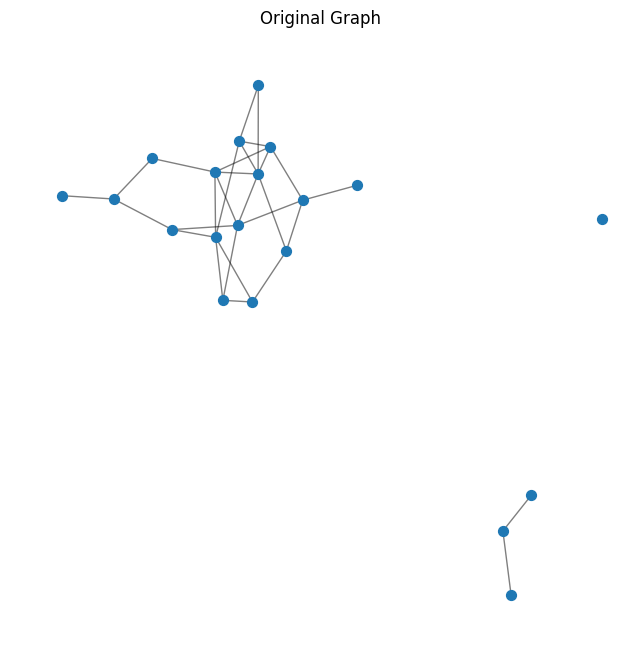

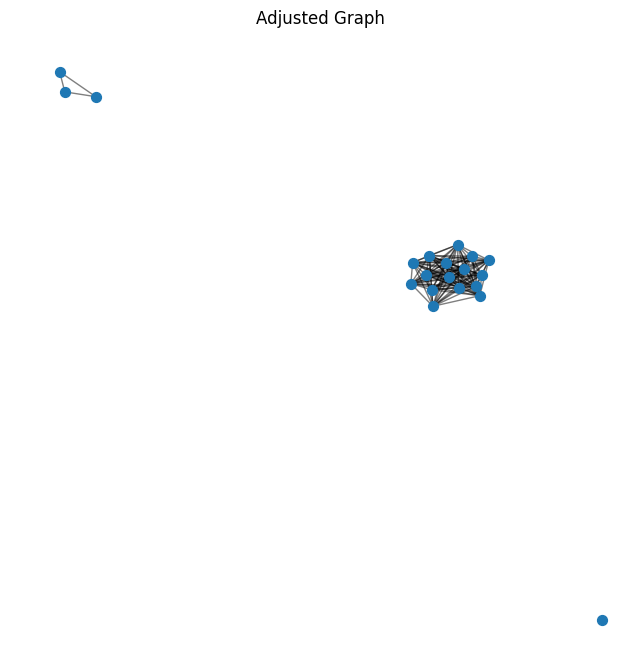

In [122]:
import matplotlib.pyplot as plt
import networkx as nx

def visualize_graph(G, title="Graph"):
    """
    Visualize a graph with Matplotlib.
    
    Parameters:
    - G: A NetworkX graph
    - title: Title for the plot
    """
    plt.figure(figsize=(8, 8))
    pos = nx.spring_layout(G)  # Position nodes using the spring layout
    nx.draw_networkx_nodes(G, pos, node_size=50)
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    plt.title(title)
    plt.axis("off")
    plt.show()

# Assuming G is your original graph and G_weighted is the adjusted graph
visualize_graph(G, title="Original Graph")
visualize_graph(G_weighted, title="Adjusted Graph")

In [123]:
def print_graph_summary(graph, name="Graph"):
    print(f"{name} - Nodes: {len(graph.nodes())}, Edges: {len(graph.edges())}")
    # Optional: Print average weight or other statistics
    if len(graph.edges()) > 0:
        average_weight = sum(nx.get_edge_attributes(graph, 'weight').values()) / len(graph.edges())
        print(f"{name} - Average Weight: {average_weight}")

print_graph_summary(G, "Original Graph")
print_graph_summary(G_weighted, "Adjusted Graph")

Original Graph - Nodes: 20, Edges: 29
Original Graph - Average Weight: 0.0
Adjusted Graph - Nodes: 20, Edges: 123
Adjusted Graph - Average Weight: 0.9741235499438754
